In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(28*3)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [10]:
client

Client Scheduler: tcp://10.148.1.2:41336 Dashboard: http://10.148.1.2:8787/status,Cluster Workers: 70 Cores: 140 Memory: 599.90 GB


_________
# 1. Read dataset


In [5]:
out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
out_dir_scratch = '/home1/scratch/xyu/OSMOSIS_llc4320/data_rechunk/'


grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_scratch+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_scratch+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_scratch+'W_total_rechunk.zarr')
ds_D = xr.open_zarr(out_dir_scratch+'Pden_total_rechunk.zarr')
ds_KPP = xr.open_zarr(out_dir_work+'KPPhbl_total_rechunk.zarr')

# buoyancy
ds_B = -9.81*(ds_D.Pden-25)/1025
ds_B = np.real(ds_B).rename('Buoy')
ds_B = ds_B.to_dataset()

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_D,ds_KPP,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 .

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic):
  * center   depth --> left
  * left     depth_left --> center


In [7]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 .

# 2. Filter

In [8]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

## 2.1 bandpass

In [9]:
lowcut = 1/120/3600
highcut = 1/30/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, [low, high], 'bandpass')

In [11]:
U_filter = butter_filter(ds.U, b, a)
chunks = {'time': 1883, 'lat': 20, 'lon_g': 17, 'depth':1}
U_filter = U_filter.chunk(chunks)
U_bandpass_filter = np.real(U_filter).rename('U_bandpass_filter')
U_bandpass_filter = U_bandpass_filter.to_dataset()
file_out = out_dir_zarr+'/U_bandpass_filter_rechunk.zarr'
%time U_bandpass_filter.to_zarr(file_out, mode='w')   

CPU times: user 2min 31s, sys: 7.32 s, total: 2min 39s
Wall time: 3min 20s


In [12]:
V_filter = butter_filter(ds.V, b, a)
chunks = {'time': 1883, 'lat_g': 20, 'lon': 17, 'depth':1}
V_filter = V_filter.chunk(chunks)
V_bandpass_filter = np.real(V_filter).rename('V_bandpass_filter')
V_bandpass_filter = V_bandpass_filter.to_dataset()
file_out = out_dir_zarr+'/V_bandpass_filter_rechunk.zarr'
%time V_bandpass_filter.to_zarr(file_out, mode='w')   

CPU times: user 2min 29s, sys: 6.42 s, total: 2min 35s
Wall time: 2min 55s


In [13]:
W_filter = butter_filter(ds.W, b, a)
chunks = {'time': 1883, 'lat': 20, 'lon': 17, 'depth':1}
W_filter = W_filter.chunk(chunks)
W_bandpass_filter = np.real(W_filter).rename('W_bandpass_filter')
W_bandpass_filter = W_bandpass_filter.to_dataset()
file_out = out_dir_zarr+'/W_bandpass_filter_rechunk.zarr'
%time W_bandpass_filter.to_zarr(file_out, mode='w')   

CPU times: user 2min 28s, sys: 9.28 s, total: 2min 37s
Wall time: 3min 1s


## 2.2 low-pass

In [14]:
lowcut = 1/120/3600
highcut = 1/30/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, low, 'low')

In [17]:
U_filter = butter_filter(ds.U, b, a)
chunks = {'time': 1883, 'lat': 20, 'lon_g': 17, 'depth':1}
U_filter = U_filter.chunk(chunks)
U_low_filter = np.real(U_filter).rename('U_low_filter')
U_low_filter = U_low_filter.to_dataset()
file_out = out_dir_zarr+'/U_lowpass_filter_rechunk.zarr'
%time U_low_filter.to_zarr(file_out, mode='w')   

CPU times: user 2min 18s, sys: 8.23 s, total: 2min 26s
Wall time: 2min 38s


In [18]:
V_filter = butter_filter(ds.V, b, a)
chunks = {'time': 1883, 'lat_g': 20, 'lon': 17, 'depth':1}
V_filter = V_filter.chunk(chunks)
V_low_filter = np.real(V_filter).rename('V_low_filter')
V_low_filter = V_low_filter.to_dataset()
file_out = out_dir_zarr+'/V_lowpass_filter_rechunk.zarr'
%time V_low_filter.to_zarr(file_out, mode='w')   

CPU times: user 2min 24s, sys: 6.81 s, total: 2min 31s
Wall time: 2min 51s


In [19]:
W_filter = butter_filter(ds.W, b, a)
chunks = {'time': 1883, 'lat': 20, 'lon': 17, 'depth':1}
W_filter = W_filter.chunk(chunks)
W_low_filter = np.real(W_filter).rename('W_low_filter')
W_low_filter = W_low_filter.to_dataset()
file_out = out_dir_zarr+'/W_lowpass_filter_rechunk.zarr'
%time W_low_filter.to_zarr(file_out, mode='w')   

CPU times: user 2min 43s, sys: 6.74 s, total: 2min 50s
Wall time: 3min 11s


# 3. read filtered data

In [20]:
grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_bandpass = xr.open_zarr(out_dir_zarr+'U_bandpass_filter_rechunk.zarr')
ds_V_bandpass = xr.open_zarr(out_dir_zarr+'V_bandpass_filter_rechunk.zarr')
ds_W_bandpass = xr.open_zarr(out_dir_zarr+'W_bandpass_filter_rechunk.zarr')

ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_filter_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_filter_rechunk.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_lowpass_filter_rechunk.zarr')

ds_filter = xr.merge([ds_U_bandpass,ds_V_bandpass,ds_W_bandpass,ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,grid])
print(ds_filter)

<xarray.Dataset>
Dimensions:            (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth              (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
    dxC                (lat, lon_g) float32 dask.array<chunksize=(20, 17), meta=np.ndarray>
    dyG                (lat, lon_g) float32 dask.array<chunksize=(20, 17), meta=np.ndarray>
    dzt                (depth) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * lat                (lat) float64 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon_g              (lon_g) float64 -18.04 -18.02 -18.0 ... -14.4 -14.38
    rAw                (lat, lon_g) float32 dask.array<chunksize=(20, 17), meta=np.ndarray>
  * time               (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
    dxG                (lat_g, lon) float32 dask.array<chunksize=(20, 17), meta=np.ndarray>
    dyC                (lat_g, lon) float32 dask.array<chunksize=(20, 17), meta=np.ndarray>
  * lat_g              

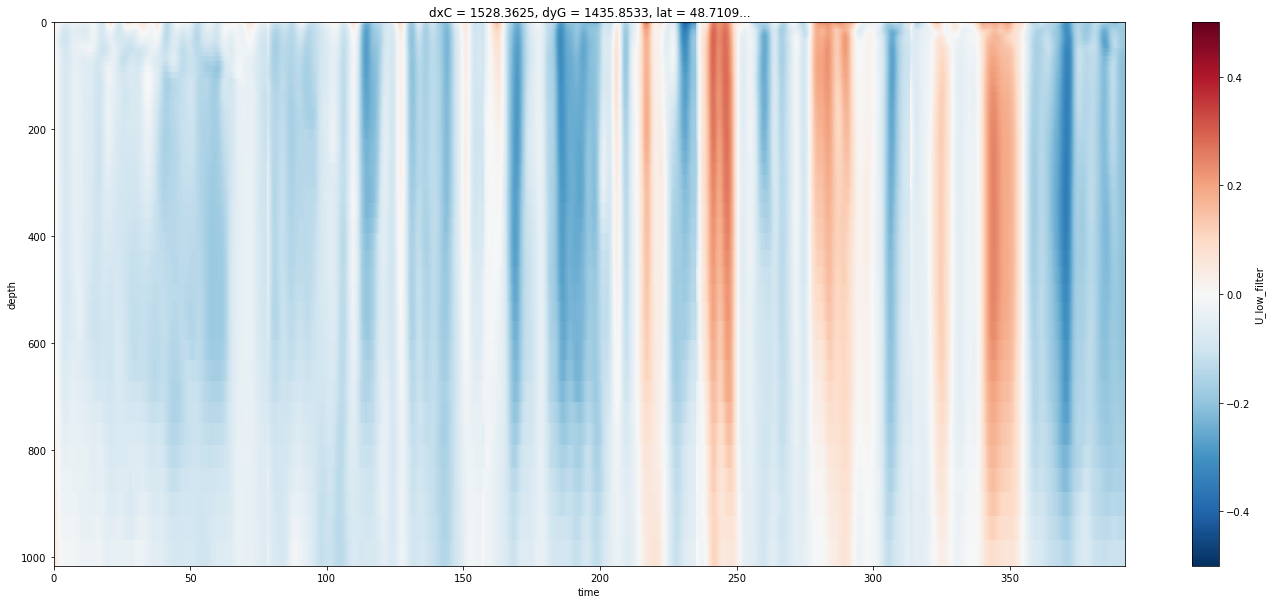

In [21]:
fig = plt.figure(figsize=(24,10))
ds_filter.U_low_filter.isel(lat=100,lon_g=100).plot(x='time', y='depth',vmin=-0.5,vmax=0.5,cmap='RdBu_r', yincrease=False)

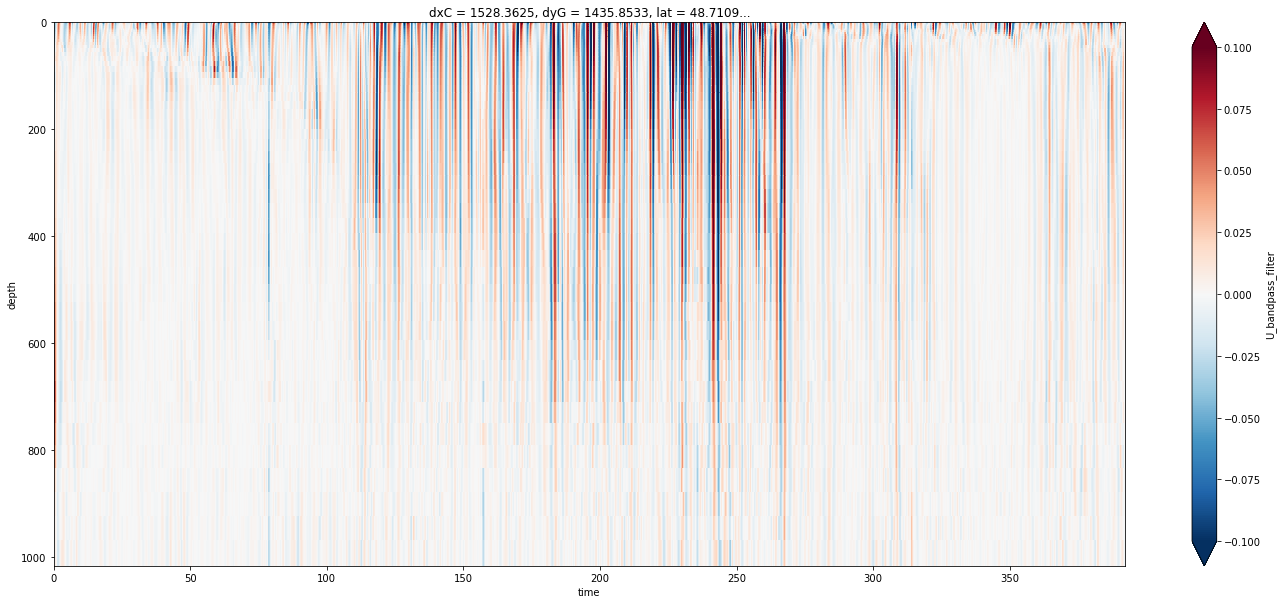

In [22]:
fig = plt.figure(figsize=(24,10))
ds_filter.U_bandpass_filter.isel(lat=100,lon_g=100).plot(x='time', y='depth',vmin=-0.1,vmax=0.1,cmap='RdBu_r', yincrease=False)

In [23]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1